In [1]:
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import gc
import xarray as xr
import pandas as pd
import xrft as xrft
import warnings
import scipy.signal as sig
import sys
import seaborn as sns
import gsw as gsw
sys.path.append("/homes/metogra/iufarias/FeedbackSubmeso/useful/")
import romspickle
# import seawater as sw

from dask.diagnostics import ProgressBar

warnings.filterwarnings("ignore")

In [2]:
def ogive(deltaf,G):
    '''
    ogive(deltaf,G): use very simple integration to calculate the ogive 
    from a spectrum G with data sampled at frequency deltaf.
    2017-01-10T09:40:31 going back to a single frequency for Os and Gs
    '''
    M1 = len(G)
    Og = np.zeros(M1,float)
    Og[0:M1] = np.cumsum(np.flipud(G[0:M1]))
    Og *= deltaf
    Og = np.flipud(Og)
    return Og



In [3]:
plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 22})

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Lucida Grande']

In [4]:
dxx=0.5

# Loading z* and $\rho$

In [5]:
z_star_full=xr.open_dataarray('/data/pacific/iufarias/z_star/z_star_full_newmethod_M01.nc')#[:,:,1:-1,1:-1]
z_star_smth=xr.open_dataarray('/data/pacific/iufarias/z_star/z_star_smth_newmethod_M01.nc')#[:,:,1:-1,1:-1]

In [6]:
rho_full=xr.open_dataarray('/data/pacific/iufarias/z_star/rho_full_M01.nc')#.loc[:,:,:,:700-1]
rho_smth=xr.open_dataarray('/data/pacific/iufarias/z_star/rho_smth_M01.nc')#.loc[:,:,:,:700-1]

In [13]:
%%time
Z_matrix=xr.DataArray(coords=(rho_full.ocean_time,
                                rho_full.z_rho.data,
                                rho_full.eta_rho.data,
                                rho_full.xi_rho.data),
                      dims=['ocean_time','z_rho','eta_rho','xi_rho'])

Z_matrix[:]=rho_full.z_rho.data[None,:,None,None]


CPU times: user 13.3 s, sys: 10min 20s, total: 10min 33s
Wall time: 13min 26s


In [17]:
%%time
# APE_full=(-(9.8)*((Z_matrix[:,:11,:,:]-z_star_full[:,:11,:,:])*rho_full[:,:11,:,:]))
# APE_smth=(-(9.8)*((Z_matrix[:,:11,:,:]-z_star_smth[:,:11,:,:])*rho_smth[:,:11,:,:]))

APE_full=(-(9.8)*((Z_matrix[:,:21,:,:]-z_star_full[:,:21,:,:])*rho_full[:,:21,:,:]))
APE_smth=(-(9.8)*((Z_matrix[:,:21,:,:]-z_star_smth[:,:21,:,:])*rho_smth[:,:21,:,:]))

CPU times: user 6.92 s, sys: 3min 11s, total: 3min 18s
Wall time: 18min 34s


# Spectral

In [18]:
nf=2
wdws='hann' #'flattop','hann'
wdw_cor=True
scl='density'

### APE squared

In [34]:
%%time
APE_squared_full=xrft.isotropic_power_spectrum(APE_full,
                dim=['eta_rho','xi_rho'],
                nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                window=wdws,window_correction=wdw_cor)
APE_squared_smth=xrft.isotropic_power_spectrum(APE_smth,
                dim=['eta_rho','xi_rho'],
                nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                window=wdws,window_correction=wdw_cor)

CPU times: user 55min 50s, sys: 4h 6min 44s, total: 5h 2min 34s
Wall time: 8min 18s


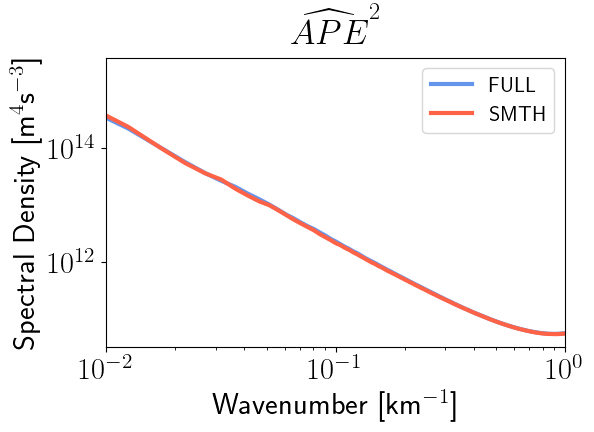

In [35]:
plt.plot(APE_squared_full.freq_r/dxx,
         APE_squared_full.mean(['ocean_time','z_rho'])/dxx*1e3,
         label='FULL',linewidth=3,color='cornflowerblue')

plt.plot(APE_squared_smth.freq_r/dxx,
         APE_squared_smth.mean(['ocean_time','z_rho'])/dxx*1e3,
         label='SMTH',linewidth=3,color='tomato')


# plt.plot([1/50,1/50],[1000,0],'k--')

plt.legend(prop={'size': 15})

plt.yscale('log')
plt.xscale('log')

# plt.title(r'$F_{PE}$',fontsize=25,y=1.05)
plt.title(r'$\widehat{APE}^2$',fontsize=25,y=1.02)




# plt.title(r'$b_S*Bo_T$',fontweight='bold',fontsize=15)
plt.ylabel(r'Spectral Density [m$^{4}$s$^{-3}$]',fontweight='bold')
plt.xlabel(r'Wavenumber  [km$^{-1}$]',fontweight='bold')


plt.xlim(1/100,1)
# plt.ylim(0,0.5e5)
# plt.grid()

plt.tight_layout()

In [36]:
dz=np.abs(np.diff(rho_full.z_rho).mean())

KAf=ogive(APE_squared_full.freq_r/dxx*1e3,(APE_squared_full.sum(['z_rho'])*dz).mean('ocean_time')/dxx*1e3) #in metersss
Kxa=APE_squared_full.freq_r/dxx #in Kilometers
KAt=ogive(APE_squared_smth.freq_r/dxx*1e3,(APE_squared_smth.sum(['z_rho'])*dz).mean('ocean_time')/dxx*1e3) #in metersss


(0.01, 1)

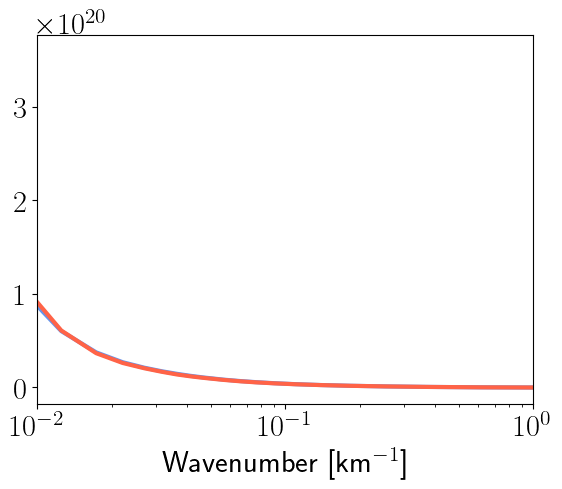

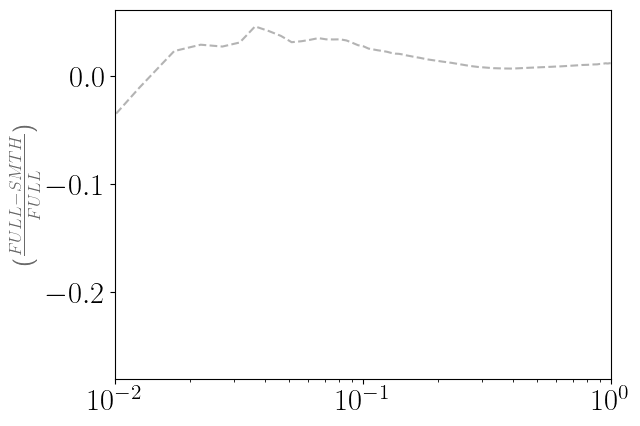

In [37]:

plt.figure()

plt.plot(Kxa,KAf,label='FULL',linewidth=3,color='cornflowerblue')
plt.plot(Kxa,KAt,label='SMTH',linewidth=3,color='tomato')
plt.xscale('log')
# plt.yscale('log')

# plt.title('a)',fontweight='bold')
# plt.ylim(0,1.3e8)


plt.xlabel(r'Wavenumber  [km$^{-1}$]',fontweight='bold')
# plt.ylabel(r'[m$^{3}\,$s$^{-2}$]',fontweight='bold',labelpad=30)
plt.xlim(1e-2,1)
# plt.ylim(-1e-1,1e11)


# # ax.legend()

plt.figure()
plt.plot((Kxa),((KAf-KAt)/(KAf)),alpha=0.5,linestyle='dashed',color='dimgray')

plt.ylabel(r'($\frac{FULL-SMTH}{FULL}$)',fontsize=18,color='dimgray')
plt.xscale('log')
plt.xlim(1e-2,1)

# plt.yticks([-0.2,-0.1])

### BPE

In [38]:
%%time
BPE_full=xrft.isotropic_cross_spectrum(rho_full[:,:21,:,:],
                xr.DataArray(z_star_full[:,:21,:,:]),dim=['eta_rho','xi_rho'],
                nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                window=wdws,window_correction=wdw_cor).real
BPE_smth=xrft.isotropic_cross_spectrum(rho_smth[:,:21,:,:],
                xr.DataArray(z_star_smth[:,:21,:,:]),dim=['eta_rho','xi_rho'],
                nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                window=wdws,window_correction=wdw_cor).real

CPU times: user 1h 48min 49s, sys: 8h 15min 41s, total: 10h 4min 31s
Wall time: 32min 56s


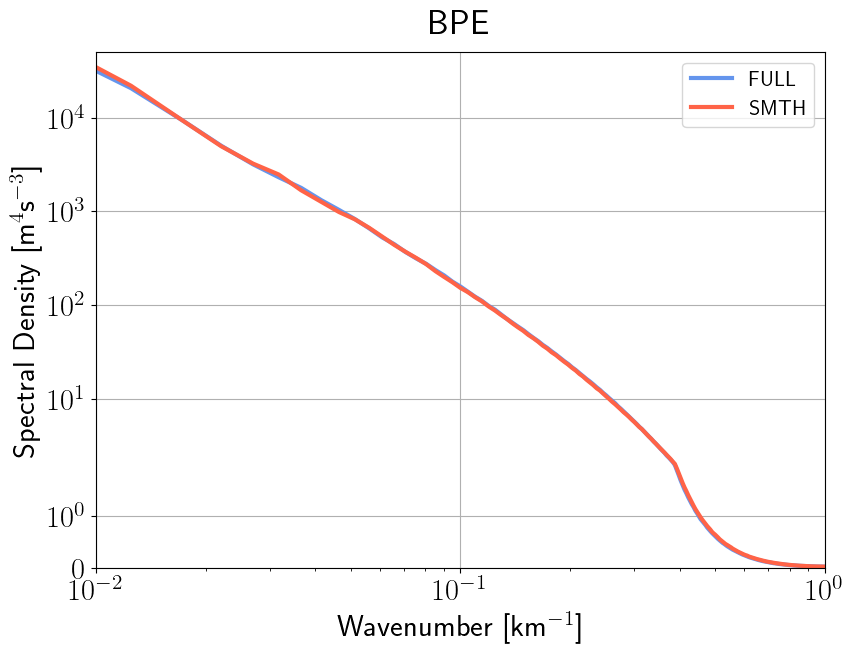

In [39]:
plt.figure(figsize=(9,7))

plt.plot(BPE_full.freq_r/dxx,
         -BPE_full.mean(['ocean_time','z_rho'])/dxx*1e3,
         label='FULL',linewidth=3,color='cornflowerblue')

plt.plot(BPE_smth.freq_r/dxx,
         -BPE_smth.mean(['ocean_time','z_rho'])/dxx*1e3,
         label='SMTH',linewidth=3,color='tomato')

# plt.plot(BPE_full.freq_r/dxx,
#          -BPE_full[:,0].mean(['ocean_time'])/dxx*1e3,
#          label='FULL',linewidth=3,color='cornflowerblue')

# plt.plot(BPE_smth.freq_r/dxx,
#          -BPE_smth[:,0].mean(['ocean_time'])/dxx*1e3,
#          label='SMTH',linewidth=3,color='tomato')


# plt.plot([1/50,1/50],[1000,0],'k--')

plt.legend(prop={'size': 15})

plt.yscale('symlog')
# # plt.yscale('log')
plt.xscale('log')
# plt.title(r'$\frac{ \,b \,Bo}{N^2_r}$',fontsize=20)

# plt.title(r'$F_{PE}$',fontsize=25,y=1.05)
plt.title(r'BPE',fontsize=25,y=1.02)


# plt.text(0.5,5e-3,r'F$_{PE}$',fontsize=25)
# plt.text(1.5e-2,0.3e-5,r'$\uparrow$ Gain ',fontsize=20)
# plt.text(1.5e-2,-0.5e-5,r'$\downarrow$ Loss ',fontsize=20)


# plt.title(r'$b_S*Bo_T$',fontweight='bold',fontsize=15)
plt.ylabel(r'Spectral Density [m$^{4}$s$^{-3}$]',fontweight='bold')
plt.xlabel(r'Wavenumber  [km$^{-1}$]',fontweight='bold')


plt.xlim(1/100,1)
plt.ylim(0,0.5e5)
plt.grid()

plt.tight_layout()

In [101]:
dz=np.abs(np.diff(rho_full.z_rho).mean())
#KE

# KAf=ogive(APE_full.freq_r/dxx*1e3,(-APE_full.sum(['z_rho'])*dz).mean('ocean_time')/dxx*1e3) #in metersss
# Kxa=APE_full.freq_r/dxx #in Kilometers
# KAt=ogive(APE_smth.freq_r/dxx*1e3,(-APE_smth.sum(['z_rho'])*dz).mean('ocean_time')/dxx*1e3) #in metersss



KAf=ogive(BPE_full.freq_r/dxx*1e3,(-BPE_full.sum(['z_rho'])*dz).mean('ocean_time')/dxx*1e3) #in metersss
Kxa=BPE_full.freq_r/dxx #in Kilometers
KAt=ogive(BPE_smth.freq_r/dxx*1e3,(-BPE_smth.sum(['z_rho'])*dz).mean('ocean_time')/dxx*1e3) #in metersss


([<matplotlib.axis.YTick at 0x7f6fc500cda0>,
 [Text(0, 0, ''), Text(0, 0, '')])

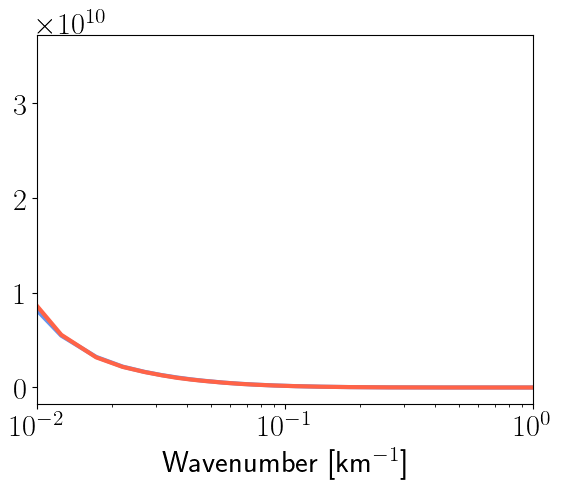

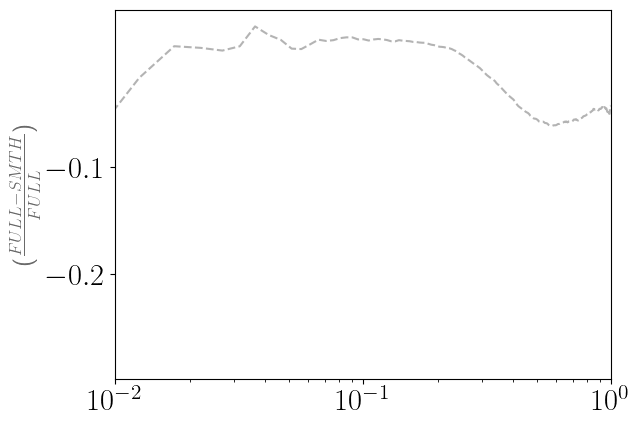

In [103]:

plt.figure()

plt.plot(Kxa,KAf,label='FULL',linewidth=3,color='cornflowerblue')
plt.plot(Kxa,KAt,label='SMTH',linewidth=3,color='tomato')
plt.xscale('log')
# plt.yscale('log')

# plt.title('a)',fontweight='bold')
# plt.ylim(0,1.3e8)


plt.xlabel(r'Wavenumber  [km$^{-1}$]',fontweight='bold')
# plt.ylabel(r'[m$^{3}\,$s$^{-2}$]',fontweight='bold',labelpad=30)
plt.xlim(1e-2,1)
# plt.ylim(-1e-1,1e11)


# # ax.legend()

plt.figure()
plt.plot((Kxa),((KAf-KAt)/(KAf)),alpha=0.5,linestyle='dashed',color='dimgray')

plt.ylabel(r'($\frac{FULL-SMTH}{FULL}$)',fontsize=18,color='dimgray')
plt.xscale('log')
plt.xlim(1e-2,1)

plt.yticks([-0.2,-0.1])

### APE co

In [40]:
APE_full=-(9.8)*xrft.isotropic_cross_spectrum((Z_matrix[:,:11,:,:]-z_star_full[:,:11,:,:]),
                xr.DataArray(rho_full[:,:11,:,:]),dim=['eta_rho','xi_rho'],
                nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                window=wdws,window_correction=wdw_cor).real
APE_smth=-(9.8)*xrft.isotropic_cross_spectrum((Z_matrix[:,:11,:,:]-z_star_smth[:,:11,:,:]),
                xr.DataArray(rho_smth[:,:11,:,:]),dim=['eta_rho','xi_rho'],
                nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                window=wdws,window_correction=wdw_cor).real

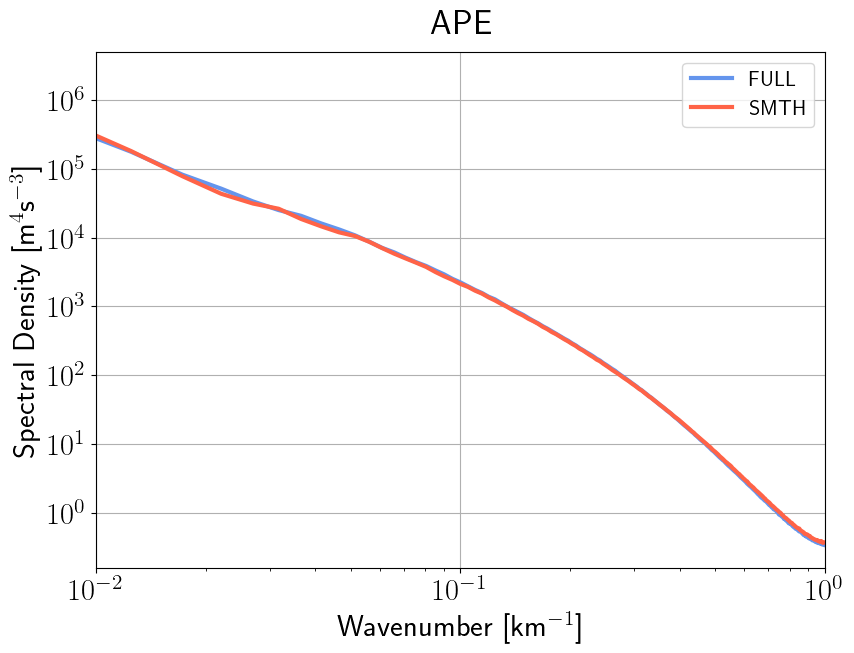

In [41]:
plt.figure(figsize=(9,7))

plt.plot(APE_full.freq_r/dxx,
         -APE_full.mean(['ocean_time','z_rho'])/dxx*1e3,
         label='FULL',linewidth=3,color='cornflowerblue')

plt.plot(APE_smth.freq_r/dxx,
         -APE_smth.mean(['ocean_time','z_rho'])/dxx*1e3,
         label='SMTH',linewidth=3,color='tomato')


# plt.plot(APE_full.freq_r/dxx,
#          -APE_full[:,0].mean(['ocean_time'])/dxx*1e3,
#          label='FULL',linewidth=3,color='cornflowerblue')

# plt.plot(APE_smth.freq_r/dxx,
#          -APE_smth[:,0].mean(['ocean_time'])/dxx*1e3,
#          label='SMTH',linewidth=3,color='tomato')

# plt.plot([1/50,1/50],[1000,0],'k--')

plt.legend(prop={'size': 15})

plt.yscale('symlog',linthresh=10**(-12))
# plt.yscale('log')
plt.xscale('log')
# plt.title(r'$\frac{ \,b \,Bo}{N^2_r}$',fontsize=20)

# plt.title(r'$F_{PE}$',fontsize=25,y=1.05)
plt.title(r'APE',fontsize=25,y=1.02)


# plt.text(0.5,5e-3,r'F$_{PE}$',fontsize=25)
# plt.text(1.5e-2,0.3e-5,r'$\uparrow$ Gain ',fontsize=20)
# plt.text(1.5e-2,-0.5e-5,r'$\downarrow$ Loss ',fontsize=20)


# plt.title(r'$b_S*Bo_T$',fontweight='bold',fontsize=15)
plt.ylabel(r'Spectral Density [m$^{4}$s$^{-3}$]',fontweight='bold')
plt.xlabel(r'Wavenumber  [km$^{-1}$]',fontweight='bold')


plt.xlim(1/100,1)
# plt.ylim(-1e-11,1e-11)
plt.grid()

plt.tight_layout()

### PE

In [42]:
%%time
PE_full=xrft.isotropic_cross_spectrum(rho_full[:,:21,:,:],
                xr.DataArray(Z_ma[:,:21,:,:]),dim=['eta_rho','xi_rho'],
                nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                window=wdws,window_correction=wdw_cor).real
PE_smth=xrft.isotropic_cross_spectrum(rho_smth[:,:21,:,:],
                xr.DataArray(Z_matrix[:,:21,:,:]),dim=['eta_rho','xi_rho'],
                nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                window=wdws,window_correction=wdw_cor).real

NameError: name 'Z_ma' is not defined

In [43]:
plt.figure(figsize=(9,7))

plt.plot(PE_full.freq_r/dxx,
         PE_full.mean(['ocean_time','z_rho'])/dxx*1e3,
         label='FULL',linewidth=3,color='cornflowerblue')

plt.plot(PE_smth.freq_r/dxx,
         PE_smth.mean(['ocean_time','z_rho'])/dxx*1e3,
         label='SMTH',linewidth=3,color='tomato')
# plt.plot(PE_full.freq_r/dxx,
#          PE_full[:,0].mean(['ocean_time'])/dxx*1e3,
#          label='FULL',linewidth=3,color='cornflowerblue')

# plt.plot(PE_smth.freq_r/dxx,
#          PE_smth[:,0].mean(['ocean_time'])/dxx*1e3,
#          label='SMTH',linewidth=3,color='tomato')


# plt.plot([1/50,1/50],[1000,0],'k--')

plt.legend(prop={'size': 15})

plt.yscale('symlog',linthresh=10**(-12))
# plt.yscale('log')
plt.xscale('log')
# plt.title(r'$\frac{ \,b \,Bo}{N^2_r}$',fontsize=20)

# plt.title(r'$F_{PE}$',fontsize=25,y=1.05)
plt.title(r'PE',fontsize=25,y=1.02)


# plt.text(0.5,5e-3,r'F$_{PE}$',fontsize=25)
# plt.text(1.5e-2,0.3e-5,r'$\uparrow$ Gain ',fontsize=20)
# plt.text(1.5e-2,-0.5e-5,r'$\downarrow$ Loss ',fontsize=20)


# plt.title(r'$b_S*Bo_T$',fontweight='bold',fontsize=15)
plt.ylabel(r'Spectral Density [m$^{4}$s$^{-3}$]',fontweight='bold')
plt.xlabel(r'Wavenumber  [km$^{-1}$]',fontweight='bold')


plt.xlim(1/100,1)
plt.ylim(-1e-11,1e-11)
plt.grid()

plt.tight_layout()

NameError: name 'PE_full' is not defined

<Figure size 900x700 with 0 Axes>

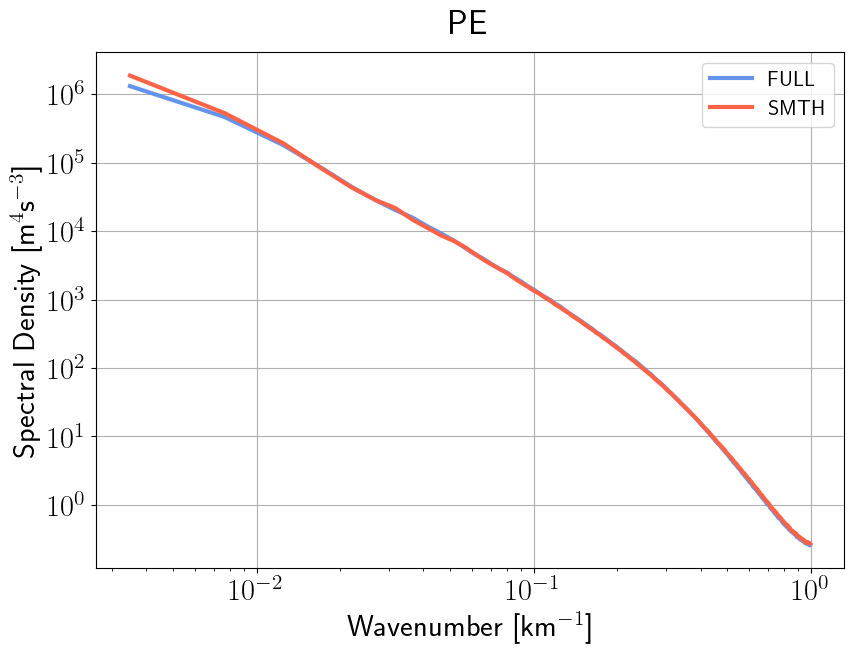

In [78]:
plt.figure(figsize=(9,7))

plt.plot(APE_full.freq_r/dxx,
         (BPE_full- APE_full).mean(['ocean_time','z_rho'])/dxx*1e3,
         label='FULL',linewidth=3,color='cornflowerblue')

plt.plot(APE_smth.freq_r/dxx,
         (BPE_smth- APE_smth).mean(['ocean_time','z_rho'])/dxx*1e3,
         label='SMTH',linewidth=3,color='tomato')
# plt.plot(PE_full.freq_r/dxx,
#          PE_full[:,0].mean(['ocean_time'])/dxx*1e3,
#          label='FULL',linewidth=3,color='cornflowerblue')

# plt.plot(PE_smth.freq_r/dxx,
#          PE_smth[:,0].mean(['ocean_time'])/dxx*1e3,
#          label='SMTH',linewidth=3,color='tomato')


# plt.plot([1/50,1/50],[1000,0],'k--')

plt.legend(prop={'size': 15})

plt.yscale('symlog',linthresh=10**(-12))
# plt.yscale('log')
plt.xscale('log')
# plt.title(r'$\frac{ \,b \,Bo}{N^2_r}$',fontsize=20)

# plt.title(r'$F_{PE}$',fontsize=25,y=1.05)
plt.title(r'PE',fontsize=25,y=1.02)


# plt.text(0.5,5e-3,r'F$_{PE}$',fontsize=25)
# plt.text(1.5e-2,0.3e-5,r'$\uparrow$ Gain ',fontsize=20)
# plt.text(1.5e-2,-0.5e-5,r'$\downarrow$ Loss ',fontsize=20)


# plt.title(r'$b_S*Bo_T$',fontweight='bold',fontsize=15)
plt.ylabel(r'Spectral Density [m$^{4}$s$^{-3}$]',fontweight='bold')
plt.xlabel(r'Wavenumber  [km$^{-1}$]',fontweight='bold')


# plt.xlim(1/100,1)
# plt.ylim(-1e-11,1e-11)
plt.grid()

plt.tight_layout()